In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, \
                                    Input, Embedding, Masking, Bidirectional, Conv1D, Flatten, \
                                    MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")
BATCH_SIZE = 32
EPOCHS = 300

from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import cx_Oracle
import pandas as pd
from sqlalchemy import create_engine

class seven_days_LSTM:
    def __init__(self, eq_id, alarm_table, hour_horizontal, hour_vertical):
        self.eq_id = eq_id
        self.alarm_table = alarm_table
        self.status_table = self.query_status()
        self.hour_horizontal = hour_horizontal
        self.hour_vertical = hour_vertical
        
        status_start = self.status_table.iloc[0]["TIMESTAMP_START"].date() + timedelta(days=1)
        status_end = self.status_table.iloc[len(self.status_table)-1]["TIMESTAMP_START"].date()
        alarm_start = self.alarm_table.iloc[0]["DT_SET"].date() + timedelta(days=1) # add one day to make it start from 00:00:00
        alarm_end = self.alarm_table.iloc[len(self.alarm_table)-1]["DT_SET"].date()
        self.start_date = max(status_start, alarm_start)
        self.end_date = min(status_end, alarm_end)
        
        self.timeframe_table = self.generate_time(self.start_date.strftime("%d/%m/%Y"), self.end_date.strftime("%d/%m/%Y"), \
                                                  self.hour_horizontal, self.hour_vertical)
        
        self.major_down_arr = self.major_down(self.timeframe_table, self.status_table, 6, 3600)

        self.X_seq = self.alarm_breakdown_pattern(self.timeframe_table, self.alarm_table, self.status_table, self.hour_horizontal)
        
    def generate_time(self, start_date:str, end_date:str, hours_row:int, hour:int):
        start = datetime.strptime(start_date, '%d/%m/%Y')
        end = datetime.strptime(end_date, '%d/%m/%Y')

        dates = []
        while start+timedelta(hours=hours_row)<=end:
            row = [start, start+timedelta(hours=hours_row)]
            dates.append(row)
            start += timedelta(hours=hour)

        return pd.DataFrame(dates, columns=['TIMESTAMP_START', 'TIMESTAMP_END'])

    
    def alarm_breakdown_pattern(self, datetime_table, alarm_table, status_table, hour):
        ORIG_ALARMS = []
        
        #validate alarm table date
        if alarm_table.iloc[0]['DT_SET'] < status_table.iloc[0]['TIMESTAMP_START'] or \
            alarm_table.iloc[len(alarm_table)-1]['DT_SET'] > status_table.iloc[len(status_table)-1]['TIMESTAMP_START']:
            raise ValueError("Alarm table date must be within the range of status table date")

        for idx, row in datetime_table.iterrows():
            start = row['TIMESTAMP_START']
            end = row['TIMESTAMP_END']

            table = alarm_table[(alarm_table['DT_SET']>=start) & (alarm_table['DT_SET']<=end)]
            new_table = table[["Alarm ID"]]
            
            tmp2 = []
            for n in new_table.values: # this part is needed to achieve the data structure in X_seq, else it would fail
                tmp2.append(n[0])
            ORIG_ALARMS.append(tmp2)

        return np.array(ORIG_ALARMS)
    
    def query_status(self):
        try:
            oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
            engine = create_engine(
                oracle_string.format(
                    username = 'TFM4CEBERUS',
                    password = 'TFM4CEBERUS',
                    hostname = 'ome-db.bth.infineon.com',
                    port = '1538',
                    database = 'ome'
                    )
                )
        except Exception as e:
            print(str(e))

        query = f"""select EQ_ID, TIMESTAMP_START, TIMESTAMP_END, DURATION, LEVEL3_NAME, LEVEL3 
                from (SELECT
                  eq.eq_id, eq.name, eq.eq_type_ident
                , data.timestamp_start,data.timestamp_end
                , ROUND((data.timestamp_end - data.timestamp_start)*24*60*60,0) AS Duration
                , data.tr25_3_status,data.tr25_4_status,data.tr25_5_status,data.eq_status
                , level5s.state_name
                , level5.state_name Level5_Name, level5.state_sign Level5
                , level4.state_name Level4_Name, level4.state_sign Level4
                , level3.state_name Level3_Name, level3.state_sign Level3
                ,mh.device
                ,mh.package,
                mh.lotid as lot,
                mh.product,
                mh.operation

                FROM OMEDATA.EQUIPMENT_STATE_HISTORY data
                , OMEADMIN.EQUIPMENT_INSTANCES eq
                , V_EQ_STATES level5s
                , OMEADMIN.DEF_STANDARD_STATEMODEL level5
                , OMEADMIN.DEF_STANDARD_STATEMODEL level4
                , OMEADMIN.DEF_STANDARD_STATEMODEL level3
                , OMEDATA.METAKEY_HISTORY mh

                WHERE data.eq_ident  = eq.eq_ident
                AND  data.eq_status = level5s.state_ident(+)
                AND level5.state_ident = data.tr25_5_status
                AND level4.state_ident = data.tr25_4_status
                AND level3.state_ident = data.tr25_3_status
                AND  data.metakey_ident =mh.ident(+)
                and data.timestamp_start > sysdate - 1500)
                where eq_id = '{self.eq_id}'
                ORDER BY TIMESTAMP_START"""

        status = pd.read_sql(query, engine)
        status.columns = map(lambda x: str(x).upper(), status.columns) 

        return status

    def major_down(self, input_table, status_table, hour, threshold):
        hour = pd.Timedelta(hours=hour)
        major_down = []
        
        # timeframe table must be a subset of the status table to correctly determine major down
        if status_table.iloc[0]["TIMESTAMP_START"] > input_table.iloc[0]["TIMESTAMP_START"]:
            raise Exception("Timeframe table must be a subset of the status table")
        if status_table.iloc[len(status_table)-1]["TIMESTAMP_START"] <= input_table.iloc[len(input_table)-1]["TIMESTAMP_START"]:
            raise Exception("Timeframe table must be a subset of the status table")   
            
        for idx, row in input_table.iterrows():
            start = row['TIMESTAMP_END']
            end = start+hour
            frame = status_table[(status_table['TIMESTAMP_START']>start) & (status_table['TIMESTAMP_START']<end)]
            UD = frame.loc[frame['LEVEL3']=='UDT']

            if len(UD) == 0: #no record within this 6 hours:
                major_down.append(0)
            else:
                time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
                if any(time_diff>threshold):
                    major_down.append(1)
                else:
                    major_down.append(0)
        return major_down

In [5]:
def find_full_alarm(eq_id, apc_alarm_table_path):
    
    alarm_apc = pd.read_excel(apc_alarm_table_path, engine="openpyxl", usecols = "B,C,D,F")
    start_date = sorted(alarm_apc["DT_SET"].dt.date)[0]
    start_date_STR = start_date.strftime("%d/%m/%Y")
    alarm_apc_new = alarm_apc.rename(columns={"Equipment": "EQ_ID", "Alarm ID": "ALARM_ID", "DT_SET": "TIMESTAMP_START", "DT_CLEAR":"TIMESTAMP_END"})
    
    try:
        oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
        engine = create_engine(
            oracle_string.format(
                username = 'TFM4CEBERUS',
                password = 'TFM4CEBERUS',
                hostname = 'ome-db.bth.infineon.com',
                port = '1538',
                database = 'ome'
            )
        )
    except Exception as e:
        print(str(e))

    query = f"""SELECT * FROM (select ei.eq_id, ea.alarm_id, ac.name as alarm_class, ah.timestamp_start,ah.timestamp_end
                from OMEADMIN.equipment_instances ei
                join OMEADMIN.equipment_alarms ea on (ei.eq_type_ident(+) = ea.eq_type_ident)
                join OMEDATA.ALARM_HISTORY ah on (ea.alarm_id = ah.alarm_id and ah.eq_ident = ei.eq_ident)
                join OMEDATA.METAKEY_HISTORY mh on (ah.metakey_ident = mh.ident)
                join OMEADMIN.EQUIPMENT_ALARM_CLASSES ac on (ac.IDENT = ea.ALARM_CLASS_IDENT and ac.eq_type_ident = ea.eq_type_ident)
                where ah.timestamp_start > sysdate - 365
                and ah.timestamp_start < sysdate -1)
                WHERE EQ_ID = '{eq_id}'
                ORDER BY TIMESTAMP_START
                """

    alarm = pd.read_sql(query, engine)
    alarm.columns = map(lambda x: str(x).upper(), alarm.columns)
    
    #map the alarm class
    all_alarm_id = alarm["ALARM_ID"].unique().tolist()
    all_alarm_dict = dict.fromkeys(all_alarm_id, None)
    
    for key in all_alarm_dict.keys():
        alarm_class = alarm[alarm.ALARM_ID ==key].iloc[0]["ALARM_CLASS"]
        all_alarm_dict[key] = alarm_class
    
    alarm_apc_new["ALARM_CLASS"] = alarm_apc_new["ALARM_ID"].map(all_alarm_dict)
    alarm_apc_new["ALARM_CLASS"] = alarm_apc_new["ALARM_CLASS"].fillna(value="Important Alarms") #those alarms cannot be found in TFM must be the important alarms
    
    filtered_alarm = alarm.loc[alarm["TIMESTAMP_START"].dt.date < start_date] # in case TFM have more data than APC, for earlier data, take from TFM
    return pd.concat([filtered_alarm, alarm_apc_new], axis=0)

# 1. Padding the alarm sequence to max length to help achieve consistent input length

In [3]:
wba124_fullalarm = find_full_alarm("WBA124", "Data/WBA124_FullAlarm.xlsx")

In [4]:
# seq_result = {}
# lookback = [6,12,18,24,48,72]
# for hour in lookback:
hour = 12
start = datetime.now()
print(f"Training by looking back {hour} hours of alarm data")
wba124 = seven_days_LSTM("WBA124", wba124_fullalarm, hour, 3)

# pad the alarm to train on LSTM
unpadded_arr = wba124.X_seq
padded_alarm = np.zeros([len(unpadded_arr),len(max(unpadded_arr,key = lambda x: len(x)))])
for i,j in enumerate(unpadded_arr):
     padded_alarm[i][0:len(j)] = j

# scale training data for the model to learn faster, because max length is taking the model too long to train per epoch
scaler = StandardScaler()
scaled_X_seq = scaler.fit_transform(padded_alarm)

#train_val_test split
val_percentage = 0.2
test_percentage = 0.1

test_index = int(len(scaled_X_seq) * (1-test_percentage))
val_index = int(len(scaled_X_seq) * (1- val_percentage - test_percentage))

X_train_seq, X_val_seq, X_test_seq = scaled_X_seq[:val_index], scaled_X_seq[val_index:test_index], scaled_X_seq[test_index:]
y_train_seq, y_val_seq, y_test_seq = wba124.y[:val_index], wba124.y[val_index:test_index], wba124.y[test_index:]

X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], 1)
X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], X_val_seq.shape[1], 1)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 1)

class_weights = class_weight.compute_class_weight('balanced',
                                             np.unique(y_train_seq),
                                             y_train_seq)
class_weights_dict = dict(enumerate(class_weights))

#need to reinitialize the model because x_train_seq changes in shape
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_seq.shape[1:]), return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(64, input_shape=(X_train_seq.shape[1:])))
model.add(Dropout(0.5))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_seq, y_train_seq, 
                batch_size=BATCH_SIZE, epochs=EPOCHS, 
                validation_data=(X_val_seq, y_val_seq), 
                class_weight=class_weights_dict)
evaluate = model.evaluate(X_test_seq, y_test_seq) #loss, mse

end = datetime.now()
time = end - start
print(f"Training took a total of {time.seconds} seconds")

Training by looking back 12 hours of alarm data
Epoch 1/150
189/189 [==============================] - 96s 490ms/step - loss: 0.6948 - accuracy: 0.5970 - val_loss: 0.6766 - val_accuracy: 0.8396
Epoch 2/150
189/189 [==============================] - 92s 487ms/step - loss: 0.6943 - accuracy: 0.5607 - val_loss: 0.7032 - val_accuracy: 0.1604
Epoch 3/150
189/189 [==============================] - 91s 483ms/step - loss: 0.6951 - accuracy: 0.6291 - val_loss: 0.6885 - val_accuracy: 0.8396
Epoch 4/150
189/189 [==============================] - 91s 482ms/step - loss: 0.6944 - accuracy: 0.5687 - val_loss: 0.7131 - val_accuracy: 0.1604
Epoch 5/150
189/189 [==============================] - 91s 482ms/step - loss: 0.6936 - accuracy: 0.3570 - val_loss: 0.6986 - val_accuracy: 0.1604
Epoch 6/150
189/189 [==============================] - 91s 483ms/step - loss: 0.6941 - accuracy: 0.2842 - val_loss: 0.6927 - val_accuracy: 0.8396
Epoch 7/150
189/189 [==============================] - 91s 481ms/step - loss

Epoch 112/150
189/189 [==============================] - 91s 484ms/step - loss: 0.6934 - accuracy: 0.3350 - val_loss: 0.7025 - val_accuracy: 0.1604
Epoch 113/150
189/189 [==============================] - 90s 479ms/step - loss: 0.6930 - accuracy: 0.2720 - val_loss: 0.7009 - val_accuracy: 0.1604
Epoch 114/150
189/189 [==============================] - 78s 412ms/step - loss: 0.6931 - accuracy: 0.3246 - val_loss: 0.6988 - val_accuracy: 0.1604
Epoch 115/150
189/189 [==============================] - 78s 414ms/step - loss: 0.6932 - accuracy: 0.1602 - val_loss: 0.6963 - val_accuracy: 0.1604
Epoch 116/150
189/189 [==============================] - 87s 461ms/step - loss: 0.6931 - accuracy: 0.1753 - val_loss: 0.6938 - val_accuracy: 0.1604
Epoch 117/150
189/189 [==============================] - 92s 486ms/step - loss: 0.6930 - accuracy: 0.6674 - val_loss: 0.6929 - val_accuracy: 0.8396
Epoch 118/150
189/189 [==============================] - 92s 485ms/step - loss: 0.6936 - accuracy: 0.5743 - val_

In [5]:
hour, evaluate

(12, [0.6960725784301758, 0.08943089097738266])

## 2. Padding the sequence with the average length
#### https://towardsdatascience.com/using-tensorflow-ragged-tensors-2af07849a7bd
#### Apparently can also greatly help boost accracy

In [3]:
wba124_fullalarm = find_full_alarm("WBA124", "Data/WBA124_FullAlarm.xlsx")

In [4]:
seq_result = {}
lookback = [6,12,18,24,48,72]
for hour in lookback:
    start = datetime.now()
    print(f"Training by looking back {hour} hours of alarm data")
    wba124 = seven_days_LSTM("WBA124", wba124_fullalarm, hour, 3)

    # pad the alarm to train on LSTM
    unpadded_arr = wba124.X_seq
    mean_length = int(np.mean([len(x) for x in unpadded_arr]))
    padded_alarm = np.zeros([len(unpadded_arr), mean_length])
    for i,j in enumerate(unpadded_arr):
        padded_alarm[i][0:len(j)] = j[:mean_length]

    # scale training data for the model to learn faster
    scaler = StandardScaler()
    scaled_X_seq = scaler.fit_transform(padded_alarm)

    #train_val_test split
    val_percentage = 0.2
    test_percentage = 0.1

    test_index = int(len(scaled_X_seq) * (1-test_percentage))
    val_index = int(len(scaled_X_seq) * (1- val_percentage - test_percentage))

    X_train_seq, X_val_seq, X_test_seq = scaled_X_seq[:val_index], scaled_X_seq[val_index:test_index], scaled_X_seq[test_index:]
    y_train_seq, y_val_seq, y_test_seq = wba124.y[:val_index], wba124.y[val_index:test_index], wba124.y[test_index:]

    X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], 1)
    X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], X_val_seq.shape[1], 1)
    X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 1)

    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_seq),
                                                 y_train_seq)
    class_weights_dict = dict(enumerate(class_weights))

    #need to reinitialize the model because x_train_seq changes in shape
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train_seq.shape[1:]), return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(64, input_shape=(X_train_seq.shape[1:])))
    model.add(Dropout(0.5))

    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation = 'softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_accuracy', mode='max', patience=5)]

    history = model.fit(X_train_seq, y_train_seq, 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_data=(X_val_seq, y_val_seq), 
                    class_weight=class_weights_dict, callbacks=callbacks)
    
    evaluate = model.evaluate(X_test_seq, y_test_seq) #loss, mse

    end = datetime.now()
    time = end - start
    seq_result[hour, mean_length] = evaluate
    print(f"Training took a total of {time.seconds} seconds")

Training by looking back 6 hours of alarm data
Epoch 1/150
189/189 [==============================] - 7s 18ms/step - loss: 0.6948 - accuracy: 0.6301 - val_loss: 0.6975 - val_accuracy: 0.1649
Epoch 2/150
189/189 [==============================] - 2s 13ms/step - loss: 0.6955 - accuracy: 0.4774 - val_loss: 0.6836 - val_accuracy: 0.7718
Epoch 3/150
189/189 [==============================] - 2s 13ms/step - loss: 0.6945 - accuracy: 0.4411 - val_loss: 0.6766 - val_accuracy: 0.7816
Epoch 4/150
189/189 [==============================] - 2s 13ms/step - loss: 0.6948 - accuracy: 0.4905 - val_loss: 0.6793 - val_accuracy: 0.7729
Epoch 5/150
189/189 [==============================] - 2s 13ms/step - loss: 0.6951 - accuracy: 0.3723 - val_loss: 0.6520 - val_accuracy: 0.7898
Epoch 6/150
189/189 [==============================] - 2s 13ms/step - loss: 0.6938 - accuracy: 0.3476 - val_loss: 0.7000 - val_accuracy: 0.1626
Epoch 7/150
189/189 [==============================] - 2s 13ms/step - loss: 0.6943 - accu

In [5]:
seq_result

{(6, 9): [0.6825759410858154, 0.6364692449569702],
 (12, 19): [0.6905587315559387, 0.6155632734298706],
 (18, 28): [0.7176927924156189, 0.09639953821897507],
 (24, 38): [0.7060851454734802, 0.2601625919342041],
 (48, 76): [0.6757280826568604, 0.880232572555542],
 (72, 114): [0.6836994290351868, 0.530849814414978]}

# 3. Training with Embedding layer
### LabelEncode the alarm id to determine n_vocab in Embedding layer
### Since max_vocab measures the maximum number of unique vocab in our input

In [3]:
def label_encode(X_seq): # do this the manual way as we are not certain if sklearn LabelEncoder can handle 3D array
    all_unique_alarms = [set(ele) for ele in X_seq]
    unique_alarms = set()
    for ele in all_unique_alarms:
        unique_alarms |= ele
    
    enc_label = 1  #start encoding from 1 as we have to pad the sequence with 0
    mapping_dict = {}
    for ele in unique_alarms:
        mapping_dict[ele] = enc_label
        enc_label += 1

        enc_array = []
        
    #X_seq is a 3D array
    for timestamp in X_seq:
        tmp_arr = []
        for ele in timestamp:
            tmp_arr.append(mapping_dict[ele])
        enc_array.append(np.array(tmp_arr))

    return np.array(enc_array), len(unique_alarms)+1, mapping_dict

In [4]:
def create_model(X_train, n_alarm):
    model = Sequential()
    model.add(Embedding(input_dim=n_alarm, output_dim=10, input_length=X_train.shape[1], mask_zero=True))
    model.add(Conv1D(256, kernel_size=3, strides=2, activation='relu'))
    model.add(Conv1D(128, 3, activation='relu'))

    model.add(LSTM(256, return_sequences=True, activation='relu'))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
    print(model.summary())
    return model

In [9]:
seq_result = {}
lookback = [12, 24, 48, 72]

monitor = 'val_recall'
mode = 'max'
hour = 24

wba127_fullalarm = pd.read_excel("../Data/WBA127_FullAlarm.xlsx", usecols = "B,C,D,F,M")
wba127 = seven_days_LSTM("WBA127", wba127_fullalarm, hour, 3)

In [10]:
encoded_X_seq, n_alarms, mapping_dict = label_encode(wba127.X_seq)
target = wba127.major_down_arr

In [11]:
# remove empty sentences
encoded_X_seq_r = []
target_r = []

for idx, ele in enumerate(encoded_X_seq):
    if len(ele)!=0:
        encoded_X_seq_r.append(ele)
        target_r.append(target[idx])

In [12]:
# padding to average length
avg_len = int(np.mean([len(ele) for ele in encoded_X_seq_r]))

padded_alarm = pad_sequences(encoded_X_seq_r,
                             maxlen=avg_len, 
                             padding='pre',
                            truncating='pre')

In [13]:
train_idx = int(0.7*len(padded_alarm))
val_idx = int(0.8*(len(padded_alarm)))

X_train, y_train = padded_alarm[:train_idx], np.array(target_r[:train_idx])
X_val, y_val = padded_alarm[train_idx:val_idx], np.array(target_r[train_idx:val_idx])
X_test, y_test = padded_alarm[val_idx:], np.array(target_r[val_idx:])

class_weights = class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train)
class_weights_dict = dict(enumerate(class_weights))

In [14]:
model = create_model(X_train, n_alarms)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 68, 10)            460       
_________________________________________________________________
conv1d (Conv1D)              (None, 33, 256)           7936      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31, 128)           98432     
_________________________________________________________________
lstm (LSTM)                  (None, 31, 256)           394240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 31, 128)           197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2

In [ ]:
model = create_model(X_train, n_alarms)

# model seems to be overfitting, try to reduce overfitting by reduce LR, but model should take longer to converge so use a larger EPOCH
callbacks = [ReduceLROnPlateau(monitor=monitor, factor=0.2, patience=5, min_lr=0.001), \
            EarlyStopping(monitor=monitor, patience=30, mode=mode, restore_best_weights=True)]

history = model.fit(X_train, y_train, 
                batch_size=BATCH_SIZE, epochs=EPOCHS, 
                validation_data=(X_val, y_val),
                class_weight=class_weights_dict,
                callbacks=callbacks)

evaluate = model.evaluate(X_test, y_test) #loss, mse

pred = model.predict(X_test)

classes = []
for ele in pred:
    classes.append(int((ele>0.5)[0]))

from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, classes)
cm

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 68, 10)            460       
_________________________________________________________________
conv1d (Conv1D)              (None, 33, 256)           7936      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31, 128)           98432     
_________________________________________________________________
lstm (LSTM)                  (None, 31, 256)           394240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 31, 128)           197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2

In [7]:
seq_result # stack Conv1D above LSTM (without removing noise)

{12: [[0.6287420988082886,
   0.5336463451385498,
   0.4633152186870575,
   0.6475076079368591],
  array([[932, 298],
         [395, 341]])],
 (12, 30): [0.6287420988082886,
  0.5336463451385498,
  0.4633152186870575,
  0.6475076079368591],
 24: [[0.6324173808097839,
   0.5170998573303223,
   0.5142857432365417,
   0.6386768221855164],
  array([[877, 353],
         [357, 378]])],
 (24, 58): [0.6324173808097839,
  0.5170998573303223,
  0.5142857432365417,
  0.6386768221855164],
 48: [[0.6813942790031433,
   0.4801097512245178,
   0.47683924436569214,
   0.6113092303276062],
  array([[850, 379],
         [384, 350]])],
 (48, 115): [0.6813942790031433,
  0.4801097512245178,
  0.47683924436569214,
  0.6113092303276062],
 72: [[0.8038536310195923,
   0.42728298902511597,
   0.5156462788581848,
   0.5596330165863037],
  array([[719, 508],
         [356, 379]])],
 (72, 169): [0.8038536310195923,
  0.42728298902511597,
  0.5156462788581848,
  0.5596330165863037]}

In [7]:
seq_result # downsample negative data

{12: [[0.6843389272689819,
   0.4783889949321747,
   0.7767145037651062,
   0.5706973671913147],
  array([[405, 531],
         [140, 487]])],
 (12, 38): [0.6843389272689819,
  0.4783889949321747,
  0.7767145037651062,
  0.5706973671913147],
 24: [[0.6756141185760498,
   0.4753146171569824,
   0.7695924639701843,
   0.5767813324928284],
  array([[448, 542],
         [147, 491]])],
 (24, 71): [0.6756141185760498,
  0.4753146171569824,
  0.7695924639701843,
  0.5767813324928284],
 48: [[0.686356782913208,
   0.4554730951786041,
   0.7577160596847534,
   0.5595026612281799],
  array([[454, 587],
         [157, 491]])],
 (48, 133): [0.686356782913208,
  0.4554730951786041,
  0.7577160596847534,
  0.5595026612281799],
 72: [[0.6810200810432434,
   0.4411483108997345,
   0.7048929929733276,
   0.5485183000564575],
  array([[483, 584],
         [193, 461]])],
 (72, 193): [0.6810200810432434,
  0.4411483108997345,
  0.7048929929733276,
  0.5485183000564575]}

In [8]:
seq_result # monitor val recall
# {72: [0.7307, 0.1300, 0.8012, 0.3925]}

{(12, 34): [0.7047469019889832,
  0.1626969575881958,
  0.7081339955329895,
  0.534690797328949],
 (24, 66): [0.7164930105209351,
  0.15516085922718048,
  0.7257053256034851,
  0.517192006111145],
 (48, 126): [0.6946452856063843,
  0.14175792038440704,
  0.7391975522041321,
  0.4753846228122711]}

In [7]:
seq_result # train on 5 machines same EQ family with shuffle and masking and empty datapoints removed

{(24, 34): [0.5954988598823547,
  0.1780264526605606,
  0.5582137107849121,
  0.6430995464324951],
 (12, 34): [0.6063371300697327,
  0.17000912129878998,
  0.5948963165283203,
  0.6087858080863953],
 (24, 66): [0.6042451858520508,
  0.1820913404226303,
  0.47492164373397827,
  0.6962750554084778],
 (48, 126): [0.5850675106048584,
  0.1593644618988037,
  0.5108024477958679,
  0.6473504304885864],
 (72, 185): [0.5972234010696411,
  0.1689220666885376,
  0.5535168051719666,
  0.6538076400756836]}

In [ ]:
seq_result # everything on top but trained on a bidirectional LSTM layer
# {12: [1.4355, 0.2238, 0.2041, 0.8222]}
# {24: [1.0140, 0.2651, 0.2962, 0.8258]}
# {48: [0.9016, 0.2873, 0.3210, 0.8366]}

# Model Architecture

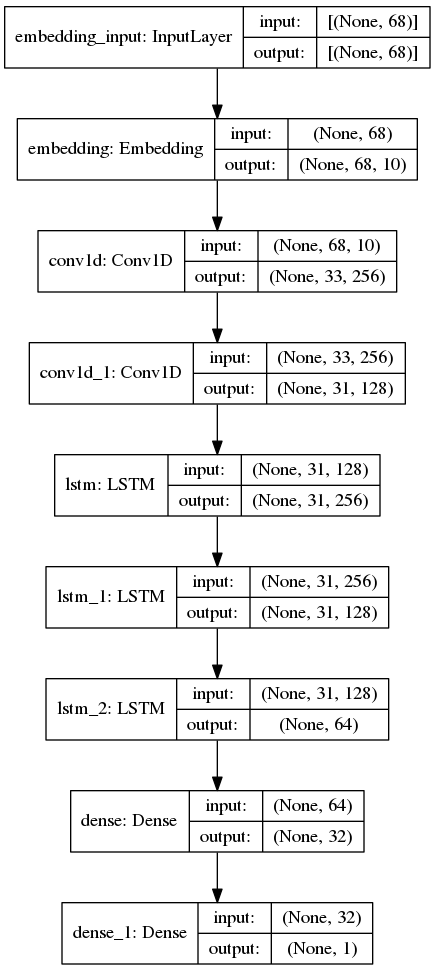

In [15]:
from keras.utils.vis_utils import plot_model

plot_model(model, 'alarm_seq.png', show_shapes=True, show_layer_names=True)

# 4. Walk forward dataset with no overlap

In [3]:
store -r wba127_clean_status

In [4]:
wba127_alarm = pd.read_excel('../Data/WBA127_FullAlarm.xlsx')

In [5]:
# 1. Compute major down for RAW alarm table
def major_down(alarm_table, status_table, hour):
    MAJOR_DOWN = []
    for idx, row in alarm_table.iterrows():
        start = row['DT_SET']
        end = start + timedelta(hours=hour)
        
        frame = status_table[(status_table['TIMESTAMP_START']>=start) &
                            (status_table['TIMESTAMP_START']<=end)]
        
        UD = frame.loc[frame['LEVEL3']=='UDT']
        
        if len(UD) == 0: #no record within this 6 hours:
            MAJOR_DOWN.append(0)
        else:
            time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
            if any(time_diff>=3600): #threshold = 3600s
                MAJOR_DOWN.append(1)
            else:
                MAJOR_DOWN.append(0)
                
    return MAJOR_DOWN

In [6]:
alarm_down = major_down(wba127_alarm, wba127_clean_status, 6)
wba127_alarm['6 HOUR DOWN'] = alarm_down

In [7]:
# 2. Use time since last alarm as another possible feature
wba127_alarm['TIME SINCE LAST ALARM'] = (wba127_alarm['DT_SET'] - wba127_alarm['DT_SET'].shift(1)).dt.total_seconds()
wba127_alarm = wba127_alarm.dropna().reset_index(drop=True)

In [8]:
df = wba127_alarm[['Alarm ID', 'TIME SINCE LAST ALARM']]
target = wba127_alarm['6 HOUR DOWN']

In [22]:
wba127_alarm[['Alarm ID', '6 HOUR DOWN']]

Alarm ID  6 HOUR DOWN
0            23            0
1            23            0
2            23            0
3            11            0
4            45            0
...         ...          ...
46197        45            1
46198        45            1
46199        28            1
46200        28            1
46201        45            1

[46202 rows x 2 columns]

In [9]:
# 3. walk forward dataset with no overlap
# 9240 samples, timestep = 5, 10

lookback_window = 10

data = []
y = []

for i in range(0, len(df), 5):
    if i>=len(df)-5:
        break
    seq = df.iloc[i:i+5]['Alarm ID'].values
    data.append(seq)
    y.append(target[i+4]) # measure major down from the last timestamp

In [10]:
# 4. Training with Embedding
enc_data, n_alarms, mapping_dict = label_encode(data)

train_idx = int(0.7*len(enc_data))
val_idx = int(0.8*(len(enc_data)))

X_train, y_train = np.array(enc_data[:train_idx]), np.array(y[:train_idx])
X_val, y_val = np.array(enc_data[train_idx:val_idx]), np.array(y[train_idx:val_idx])
X_test, y_test = np.array(enc_data[val_idx:]), np.array(y[val_idx:])

In [23]:
mapping_dict

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 8: 7,
 9: 8,
 11: 9,
 12: 10,
 13: 11,
 14: 12,
 18: 13,
 20: 14,
 23: 15,
 24: 16,
 25: 17,
 26: 18,
 27: 19,
 28: 20,
 31: 21,
 33: 22,
 34: 23,
 35: 24,
 44: 25,
 45: 26,
 47: 27,
 49: 28,
 50: 29,
 51: 30,
 61: 31,
 65: 32,
 73: 33,
 80: 34,
 100: 35,
 245: 36}

In [18]:
#5. Define model, use the same model as above

model = Sequential()
model.add(Embedding(input_dim=n_alarms, output_dim=10, input_length=X_train.shape[1], mask_zero=True))
model.add(Conv1D(256, kernel_size=3, strides=2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(10, activation="relu"))
model.add(Dense(1,  activation="sigmoid"))  

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

In [19]:
#6. Compute class weight to achieve balance between two classes

class_weights = class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train)
class_weights_dict = dict(enumerate(class_weights))


callbacks = [ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.001), \
            EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)]

history = model.fit(X_train, y_train, 
                batch_size=BATCH_SIZE, epochs=EPOCHS, 
                validation_data=(X_val, y_val),
                class_weight=class_weights_dict,
                callbacks=callbacks)

evaluate = model.evaluate(X_test, y_test) #loss, mse

pred = model.predict(X_test)

classes = []
for ele in pred:
    classes.append(int((ele>0.5)[0]))

from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, classes)
cm

Epoch 1/300
203/203 [==============================] - 2s 3ms/step - loss: 0.6687 - precision_1: 0.2192 - recall_1: 0.5313 - accuracy: 0.6331 - val_loss: 0.6883 - val_precision_1: 0.1184 - val_recall_1: 0.7000 - val_accuracy: 0.5227
Epoch 2/300
203/203 [==============================] - 0s 2ms/step - loss: 0.6468 - precision_1: 0.2297 - recall_1: 0.7005 - accuracy: 0.5884 - val_loss: 0.6757 - val_precision_1: 0.1213 - val_recall_1: 0.6750 - val_accuracy: 0.5487
Epoch 3/300
203/203 [==============================] - 0s 2ms/step - loss: 0.6419 - precision_1: 0.2355 - recall_1: 0.7055 - accuracy: 0.5985 - val_loss: 0.6351 - val_precision_1: 0.1268 - val_recall_1: 0.5625 - val_accuracy: 0.6266
Epoch 4/300
203/203 [==============================] - 0s 2ms/step - loss: 0.6392 - precision_1: 0.2323 - recall_1: 0.6925 - accuracy: 0.5966 - val_loss: 0.7262 - val_precision_1: 0.1143 - val_recall_1: 0.7375 - val_accuracy: 0.4827
Epoch 5/300
203/203 [==============================] - 0s 2ms/step -

203/203 [==============================] - 0s 2ms/step - loss: 0.5218 - precision_1: 0.2897 - recall_1: 0.8090 - accuracy: 0.6622 - val_loss: 0.7519 - val_precision_1: 0.0925 - val_recall_1: 0.5375 - val_accuracy: 0.5032
Epoch 37/300
203/203 [==============================] - 0s 2ms/step - loss: 0.5207 - precision_1: 0.2914 - recall_1: 0.7980 - accuracy: 0.6671 - val_loss: 0.8362 - val_precision_1: 0.0884 - val_recall_1: 0.6125 - val_accuracy: 0.4199
Epoch 38/300
203/203 [==============================] - 0s 2ms/step - loss: 0.5161 - precision_1: 0.2911 - recall_1: 0.8209 - accuracy: 0.6616 - val_loss: 0.7640 - val_precision_1: 0.1084 - val_recall_1: 0.5500 - val_accuracy: 0.5693
Epoch 39/300
203/203 [==============================] - 0s 2ms/step - loss: 0.5114 - precision_1: 0.3064 - recall_1: 0.7891 - accuracy: 0.6897 - val_loss: 0.8913 - val_precision_1: 0.0926 - val_recall_1: 0.6250 - val_accuracy: 0.4372
Epoch 40/300
203/203 [==============================] - 0s 2ms/step - loss: 0

array([[1064,  334],
       [ 326,  124]])

In [13]:
# seems like accuracy not improving, check data
pos_idx = np.where([i==1 for i in y_train])[0]
check_df = X_train[pos_idx]

In [14]:
c = pd.DataFrame(columns=['Seq', 'Target'])
for idx, ele in enumerate(check_df):
    c = c.append({'Seq':ele, 'Target':y[idx]}, ignore_index=True)

In [15]:
c

Seq Target
0     [19, 25, 25, 16, 26]      0
1      [9, 25, 26, 30, 10]      0
2         [9, 33, 9, 9, 9]      0
3       [20, 20, 9, 9, 25]      0
4      [25, 25, 25, 9, 33]      0
...                    ...    ...
1000  [20, 20, 15, 15, 15]      0
1001  [20, 20, 25, 20, 20]      0
1002  [20, 20, 20, 20, 16]      0
1003  [16, 26, 20, 16, 26]      0
1004  [26, 30, 20, 20, 30]      0

[1005 rows x 2 columns]

# 5. Remove alarm id from the front during padding

In [ ]:
enc_wba124_X_seq, n_alarm_wba124, mapping_dict_wba124 = label_encode(wba124.X_seq)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

feature = pad_sequences(enc_wba124_X_seq, maxlen=n_alarm_wba124, value=0, 
                         truncating='pre', padding='pre') 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(feature, wba124.major_down_arr, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.4)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
weights ={}
for idx, val in enumerate(class_weights):
    weights[idx] = val
weights

In [ ]:
# fit and predict

model = Sequential()
model.add(Embedding(n_alarm_wba124, 128, input_length=feature.shape[1], mask_zero=True))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_accuracy', mode='max', patience=5)]

model.fit(np.array(X_train), np.array(y_train), 
          epochs=10, 
          batch_size=BATCH_SIZE,
          verbose = 1,
          class_weight=weights,
          callbacks=callbacks,
          validation_data=(X_val, np.array(y_val)))

pred = model.predict(X_test)

classes = []
for ele in pred:
    classes.append(int((ele>0.5)[0]))

print(confusion_matrix(np.array(y_test), classes)), accuracy_score(np.array(y_test), classes)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def to_labels(y_scores, threshold):
    return (y_scores >= threshold).astype('int')

fpr, tpr, thresholds = roc_curve(np.array(y_test), classes)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

testest = to_labels(classes, best_thresh) # best thresh optimizes recall
confusion_matrix(np.array(y_test), testest), accuracy_score(np.array(y_test), testest)

# 6. Sample Weighing Alarm ID

In [14]:
# load in data

wba123_fullalarm = pd.read_excel("../Data/WBA123_FullAlarm.xlsx", usecols = "B,C,D,F,M")
wba123 = seven_days_LSTM("WBA123", wba123_fullalarm, 24, 3)

wba124_fullalarm = pd.read_excel("../Data/WBA124_FullAlarm.xlsx", usecols = "B,C,D,F,M")
wba124 = seven_days_LSTM("WBA124", wba124_fullalarm, 24, 3)

wba126_fullalarm = pd.read_excel("../Data/WBA126_FullAlarm.xlsx", usecols = "B,C,D,F,M")
wba126 = seven_days_LSTM("WBA126", wba126_fullalarm, 24, 3)

wba127_fullalarm = pd.read_excel("../Data/WBA127_FullAlarm.xlsx", usecols = "B,C,D,F,M")
wba127 = seven_days_LSTM("WBA127", wba127_fullalarm, 24, 3)

wba128_fullalarm = pd.read_excel("../Data/WBA128_FullAlarm.xlsx", usecols = "B,C,D,F,M")
wba128 = seven_days_LSTM("WBA128", wba128_fullalarm, 24, 3)

In [15]:
tmp1 = np.concatenate((wba123.X_seq, wba124.X_seq, wba126.X_seq, wba127.X_seq, wba128.X_seq))
encoded_X_seq, n_alarms, mapping_dict = label_encode(tmp1)
target = np.concatenate((wba123.major_down_arr, wba124.major_down_arr, wba126.major_down_arr, wba127.major_down_arr, wba128.major_down_arr))

In [16]:
empty_alarms_index = []
for i in range(encoded_X_seq.shape[0]):
    if encoded_X_seq[i].shape[0]==0:
        empty_alarms_index.append(i)
        
y_values_for_empty_alarms = [target[i] for i in empty_alarms_index]
from collections import Counter
Counter(y_values_for_empty_alarms)
#There are only 604 records of EMPTY alarms which cause breakdown (target = 1) out of 43000 -> very little, only 1%. 
#So these empty alarms records will be removed. 

# Remove empty alarms
encoded_X_seq_no_empty = np.delete(encoded_X_seq,empty_alarms_index)
encoded_X_seq_no_empty.shape[0]
target_no_empty_alarms = np.delete(target,empty_alarms_index)
target_no_empty_alarms.shape[0]

34894

#### Sample weighting - generate weight for each alarm ID

In [17]:
#Determining Sampling weights
all_alarms = np.concatenate(encoded_X_seq_no_empty,axis = 0) #combining all ALARMS appear in X INTO 1 LIST
#Counter(all_alarms).keys()

alarm_weight = dict()
for key in Counter(all_alarms).keys():
    alarm_weight[key] = (all_alarms.shape[0]/all_alarms[key])/10000

#100 alarms, alarm ID 44 appear 3 times. the 100/3 = 33

alarm_weight[0] = 0 #For zeros value in X (to ignore the padding)
alarm_weight

{25: 5.266695454545454,
 11: 5.517490476190476,
 34: 46.346920000000004,
 4: 21.066781818181816,
 42: 9.269384,
 46: 5.517490476190476,
 44: 5.517490476190476,
 33: 46.346920000000004,
 17: 5.517490476190476,
 5: 57.93365,
 29: 6.815723529411765,
 24: 5.266695454545454,
 19: 5.517490476190476,
 32: 46.346920000000004,
 21: 5.517490476190476,
 20: 5.517490476190476,
 12: 6.815723529411765,
 38: 57.93365,
 10: 6.815723529411765,
 6: 9.269384,
 35: 9.269384,
 2: 6.815723529411765,
 31: 5.517490476190476,
 13: 5.517490476190476,
 3: 6.815723529411765,
 14: 5.517490476190476,
 47: 5.517490476190476,
 41: 9.269384,
 22: 5.0377086956521735,
 16: 6.815723529411765,
 18: 6.815723529411765,
 15: 6.815723529411765,
 23: 5.517490476190476,
 8: 9.269384,
 48: 6.815723529411765,
 37: 21.066781818181816,
 36: 5.517490476190476,
 43: 6.815723529411765,
 52: 5.517490476190476,
 49: 6.815723529411765,
 9: 9.269384,
 39: 9.269384,
 28: 5.517490476190476,
 26: 7.022260606060606,
 53: 5.517490476190476,
 4

#### Last n alarms data preprocessing

In [18]:
# last_5['length==5'] = [len(last_5['last_5_alarms'][i])==5 for i in range(last_5.shape[0])]
# last_5.loc[(last_5['length==5'] == False)] #There are 703 rows where the number of alarms in that timeframe <5. 
# #Out of these 703 records, only 49 are major down. So we will remove these records. 
# #last_5.loc[(last_5['length==5'] == False) & (last_5['target'] == 1)]

In [19]:
#Drop duplicates (duplication = no alarms happen in the 3 hours period between rows)
last_5_clean = last_5_clean[['last_5_alarms','target']]
last_5_clean['str_version'] = last_5_clean['last_5_alarms'].astype(str)
duplicate = last_5_clean.duplicated(subset=['str_version'])

index_duplicate = [i for i,x in enumerate(duplicate) if x]

NameError: name 'last_5_clean' is not defined

In [ ]:
l5nd = last_5_clean.drop_duplicates(subset=['str_version']) #l5nd = last 5 clean no duplicates 
pd.set_option("display.max_rows",100)
l5nd['target'].value_counts()
l5nd_sf = l5nd.sample(frac=1,random_state = 3)
l5nd_sf = l5nd_sf.reset_index(drop=True)

In [ ]:
#Padding data with alarm sequence length <5 
pad_last_alarms = pad_sequences(
    l5nd_sf['last_5_alarms'], maxlen=5, dtype='int32', padding='pre',
    truncating='pre', value=0)

In [ ]:
from sklearn.model_selection import train_test_split
X_tr_last,X_ts_last,y_tr_last,y_ts_last = train_test_split(pad_last_alarms,l5nd_sf['target'],stratify = l5nd_sf['target'], test_size = 0.2, random_state = 43)

from collections import Counter 
Counter(y_ts_last)

In [ ]:
#model_weight: to be fit inside model.fit Keras API
modelwtr_last = np.zeros((X_tr_last.shape[0],5))
for i in range(modelwtr_last.shape[0]):
    for j in range(5):
        modelwtr_last[i,j] = alarm_weight[(X_tr_last[i][j])]
        
#FOR TEST 
modelwts_last = np.zeros((X_ts_last.shape[0],5)) #initialize model_weight
#model_weight: to be fit inside model.fit Keras API
for i in range(modelwts_last.shape[0]):
    for j in range(5):
        modelwts_last[i,j] = alarm_weight[(X_ts_last[i][j])]
        
#Changing to 1D
mw1dtr_last = np.array([modelwtr_last[i].sum()/(modelwtr_last.shape[1]*30) for i in range(modelwtr_last.shape[0])])
mw1dts_last = np.array([modelwts_last[i].sum()/(modelwts_last.shape[1]*30) for i in range(modelwts_last.shape[0])])

In [ ]:
#SMOTE
from imblearn.over_sampling import BorderlineSMOTE
oversample = BorderlineSMOTE()
X_tr_last_sm, y_tr_last_sm = oversample.fit_resample(X_tr_last,y_tr_last)

In [ ]:
#Model weight for SMOTE dataset
#model_weight: to be fit inside model.fit Keras API
modelwtr_last_sm = np.zeros((X_tr_last_sm.shape[0],5))

for i in range(modelwtr_last_sm.shape[0]):
    for j in range(5):
        modelwtr_last_sm[i,j] = alarm_weight[(X_tr_last_sm[i][j])]
        
#Changing to 1D
mw1dtr_last_sm = np.array([modelwtr_last_sm[i].sum()/(modelwtr_last_sm.shape[1]*30) for i in range(modelwtr_last_sm.shape[0])])

#### Generate Sample weight for both training & test set (for model.fit & model.evaluate) 

In [ ]:
# one sample weight for training and another for test

#FOR TRAINING
model_weight_tr = np.zeros((pad_X_tr_smote.shape[0],pad_X_tr_smote.shape[1])) #initialize model_weight
#model_weight: to be fit inside model.fit Keras API
for i in range(model_weight_tr.shape[0]):
    for j in range(model_weight_tr.shape[1]):
        model_weight_tr[i,j] = alarm_weight[(pad_X_tr_smote[i][j])]

#FOR TEST
model_weight_ts = np.zeros((pad_X_ts.shape[0],pad_X_ts.shape[1])) #initialize model_weight
#model_weight: to be fit inside model.fit Keras API
for i in range(model_weight_ts.shape[0]):
    for j in range(model_weight_ts.shape[1]):
        model_weight_ts[i,j] = alarm_weight[(pad_X_ts[i][j])]

In [ ]:
# take mean sample of the sample weight as the sample weight for the general sentence

model_weight_1D_tr = np.array([model_weight_tr[i].sum()/(model_weight_tr.shape[1]*30) for i in range(model_weight_tr.shape[0])])
model_weight_1D_ts = np.array([model_weight_ts[i].sum()/(model_weight_ts.shape[1]*30) for i in range(model_weight_ts.shape[0])])
                                                                                            
#model_weight[i].sum()/model_weight.shape[1] = taking the average of ALL the weights in the i-th row of model_weight

#### Modelling

In [ ]:
#input_length = pad_X_tr_smote.shape[1]
input_length = 5 #for last_5 alarms data

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_tr_last)
                                               ,y_tr_last)

In [ ]:
model = Sequential()

model.add(Embedding(100, 200, input_length = input_length, mask_zero=True))
model.add(LSTM(32,return_sequences=True,dropout=0.1))
model.add(LSTM(32,return_sequences=True,dropout=0.1))
model.add(LSTM(32))
model.add(Dense(64,activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

model.summary()
history = model.fit(X_tr_last_sm, y_tr_last_sm, epochs=1, 
                    sample_weight = mw1dtr_last_sm)

evaluate = model.evaluate(X_ts_last, y_ts_last, sample_weight = mw1dts_last)

In [ ]:
#Prediction for last alarms 
from sklearn.metrics import classification_report, confusion_matrix
y_pred_last = model.predict(X_ts_last)

#Finding the correct threshold for the prediction probability 
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_ts_last, y_pred_last)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

y_pred_classes = [1 if i>=0.19547457 else 0 for i in y_pred_last]

print(confusion_matrix(y_ts_last,y_pred_classes))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print('Precision: ', precision_score(y_ts_last, y_pred_classes))
print('Recall: ',recall_score(y_ts_last,y_pred_classes))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(pad_X_ts)

#Finding the correct threshold for the prediction probability 
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_ts, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

y_pred_classes = [1 if i>=0.19547457 else 0 for i in y_pred]

print(confusion_matrix(y_ts,y_pred_classes))
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print('Precision: ', precision_score(y_ts, y_pred_classes))
print('Recall: ',recall_score(y_ts,y_pred_classes))